# Làm sạch dữ liệu & chuẩn hóa dữ liệu

In [2]:
import pandas as pd
from DataCleaning import DataCleaner

# Đọc dữ liệu từ file CSV
df_raw = pd.read_csv("NLG.csv")
# Kiểm tra xem dữ liệu đã được đọc thành công
cleaner = DataCleaner(df_raw)
df_cleaned = cleaner.run_all()

# Lưu dữ liệu sau khi làm sạch (tuỳ chọn)
df_cleaned.to_csv("NLG_cleaned.csv", index=False)
print("Đã lưu dữ liệu làm sạch vào NLG_cleaned.csv")

Chuyển đổi cột 'time' sang datetime...
Xử lý missing values: 1049 giá trị thiếu trước khi xử lý.
Còn lại 0 missing sau xử lý.
Số dòng trùng lặp cần loại bỏ: 0
Phát hiện và xử lý outlier bằng IQR...
Cột có outliers được xử lý: ['ceiling_price', 'floor_price', 'reference_price', 'open_price', 'close_price', 'match_price', 'price_change', 'percent_price_change', 'highest_price', 'lowest_price', 'average_price', 'total_match_volume', 'total_match_value', 'total_deal_volume', 'total_deal_value', 'total_volume', 'total_value', 'foreign_net_trading_volume', 'foreign_net_trading_value', 'foreign_buy_value_matched', 'foreign_buy_volume_matched', 'foreign_sell_value_matched', 'foreign_sell_volume_matched', 'foreign_buy_value_deal', 'foreign_buy_volume_deal', 'foreign_sell_value_deal', 'foreign_sell_volume_deal', 'foreign_buy_value_total', 'foreign_buy_volume_total', 'foreign_sell_value_total', 'foreign_sell_volume_total', 'foreign_current_room', 'total_trade', 'total_buy_trade', 'total_buy_trade

In [ ]:
from DataNormalization import DataNormalizer
import pandas as pd

df_raw = pd.read_csv("NLG_cleaned.csv")

normalizer = DataNormalizer(df_raw, scaler_type='robust', exclude_columns=[
    'percent_price_change', 'percent_price_change_adjusted'
])
df_scaled = normalizer.run_all()

# Lưu dữ liệu sau khi chuẩn hóa dữ liệu (tuỳ chọn)
df_scaled.to_csv("NLG_normalized.csv", index=False)
print("Đã lưu dữ liệu làm sạch vào NLG_normalized.csv")


# BƯỚC 1: Khám phá biến động giá & khối lượng
    Line chart giá đóng cửa (close_price_adjusted)
    Overlay khối lượng giao dịch (total_match_volume)
    Trực quan nến (OHLC)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu đã làm sạch (đảm bảo file NLG_cleaned.csv có sẵn cùng thư mục)
df = pd.read_csv("NLG_cleaned.csv")

# Chuyển cột 'time' về dạng datetime và đặt làm chỉ số
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# ------------------------------------------
# 📈 BIỂU ĐỒ 1: Giá đóng cửa điều chỉnh (close_price_adjusted)
# ------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(df['close_price_adjusted'], label='Giá đóng cửa điều chỉnh', color='darkblue')
plt.title("Biểu đồ giá đóng cửa điều chỉnh – Cổ phiếu NLG")
plt.xlabel("Thời gian")
plt.ylabel("Giá (VND)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------
# 📊 BIỂU ĐỒ 2: Khối lượng khớp lệnh (total_match_volume)
# ------------------------------------------
plt.figure(figsize=(14, 4))
plt.plot(df['total_match_volume'], label='Khối lượng khớp lệnh', color='darkgray')
plt.title("Biểu đồ khối lượng khớp lệnh – Cổ phiếu NLG")
plt.xlabel("Thời gian")
plt.ylabel("Khối lượng")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


: 

# BƯỚC 2 – PHASE 1: Tính toán và trực quan hóa các chỉ báo kỹ thuật:

🎯 MA10, MA20, MA50

📈 Bollinger Bands (±2σ)

📉 RSI (Relative Strength Index)

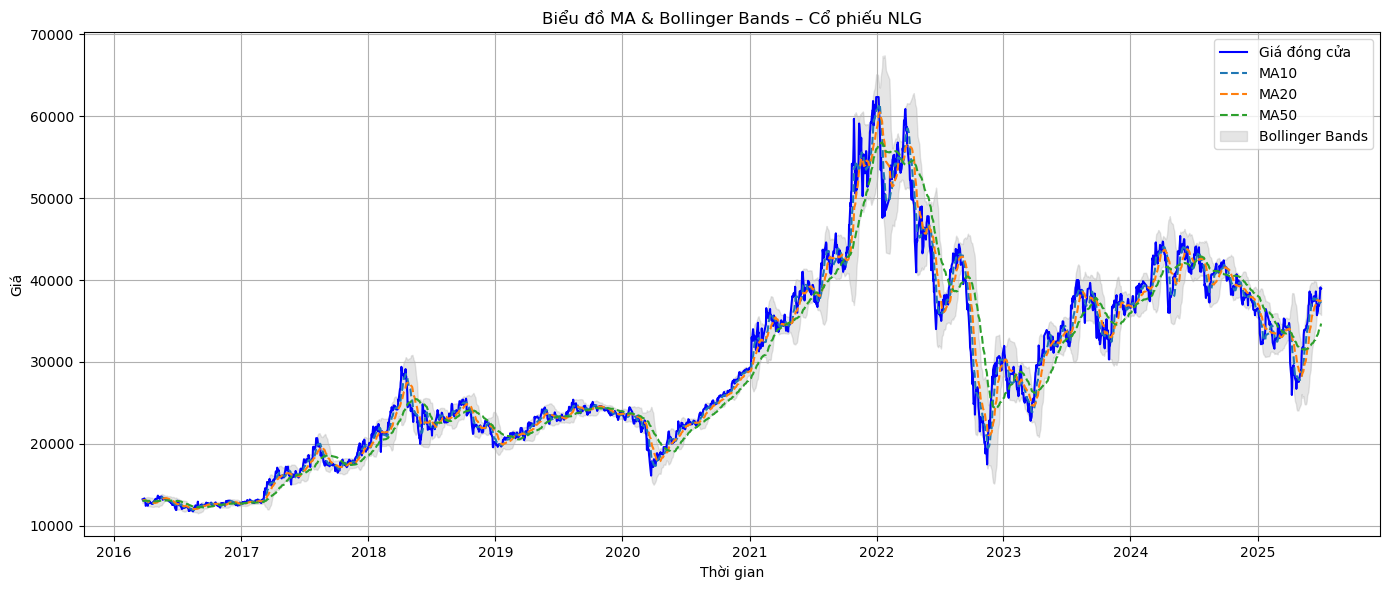

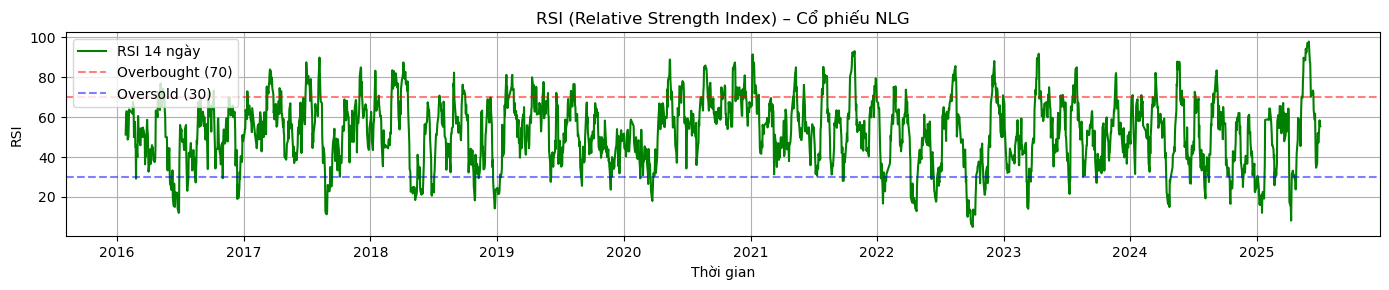

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Đọc dữ liệu đã làm sạch
df = pd.read_csv("NLG_cleaned.csv")
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Tính MA10, MA20, MA50
df['MA10'] = df['close_price_adjusted'].rolling(window=10).mean()
df['MA20'] = df['close_price_adjusted'].rolling(window=20).mean()
df['MA50'] = df['close_price_adjusted'].rolling(window=50).mean()

# Tính Bollinger Bands (MA20 ± 2 * rolling std)
rolling_std = df['close_price_adjusted'].rolling(window=20).std()
df['Bollinger_Upper'] = df['MA20'] + 2 * rolling_std
df['Bollinger_Lower'] = df['MA20'] - 2 * rolling_std

# Tính RSI 14 ngày
delta = df['close_price_adjusted'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# =====================================
# 📊 VẼ MA và BOLLINGER BANDS
# =====================================
df_ma = df[['close_price_adjusted', 'MA10', 'MA20', 'MA50',
            'Bollinger_Upper', 'Bollinger_Lower']].dropna()

plt.figure(figsize=(14, 6))
plt.plot(df_ma['close_price_adjusted'], label='Giá đóng cửa', color='blue')
plt.plot(df_ma['MA10'], label='MA10', linestyle='--')
plt.plot(df_ma['MA20'], label='MA20', linestyle='--')
plt.plot(df_ma['MA50'], label='MA50', linestyle='--')
plt.fill_between(df_ma.index,
                 df_ma['Bollinger_Upper'],
                 df_ma['Bollinger_Lower'],
                 color='gray', alpha=0.2, label='Bollinger Bands')
plt.title("Biểu đồ MA & Bollinger Bands – Cổ phiếu NLG")
plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================
# 📉 VẼ RSI
# =====================================
df_rsi = df[['RSI']].dropna()

plt.figure(figsize=(14, 3))
plt.plot(df_rsi.index, df_rsi['RSI'], label='RSI 14 ngày', color='green')
plt.axhline(70, linestyle='--', color='red', alpha=0.5, label='Overbought (70)')
plt.axhline(30, linestyle='--', color='blue', alpha=0.5, label='Oversold (30)')
plt.title("RSI (Relative Strength Index) – Cổ phiếu NLG")
plt.xlabel("Thời gian")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# BƯỚC 3 – PHASE 1: Tính và trực quan hoá các chỉ số thống kê kỹ thuật:

📊 Daily Return (% thay đổi giá)

⚡ Volatility (độ biến động rolling 20 ngày)

📉 Max Drawdown (tỷ lệ sụt giảm lớn nhất từ đỉnh)

C:\Users\Welcome\AppData\Local\Temp\ipykernel_26012\4012266069.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Welcome\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


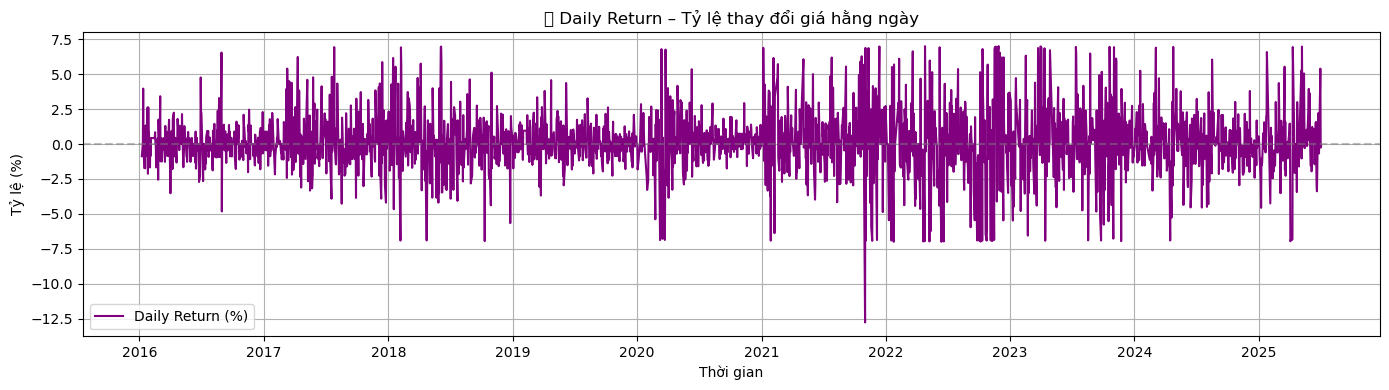

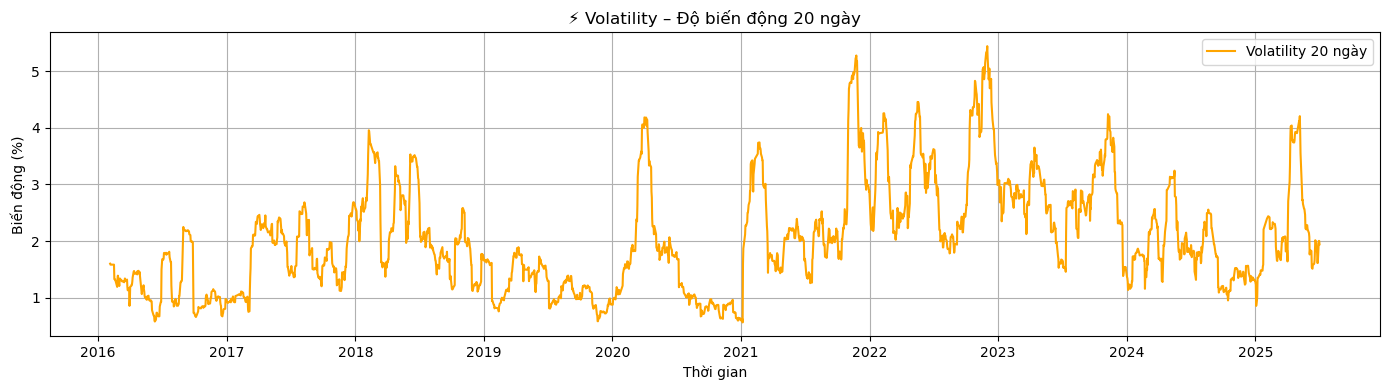

C:\Users\Welcome\AppData\Local\Temp\ipykernel_26012\4012266069.py:57: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Welcome\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


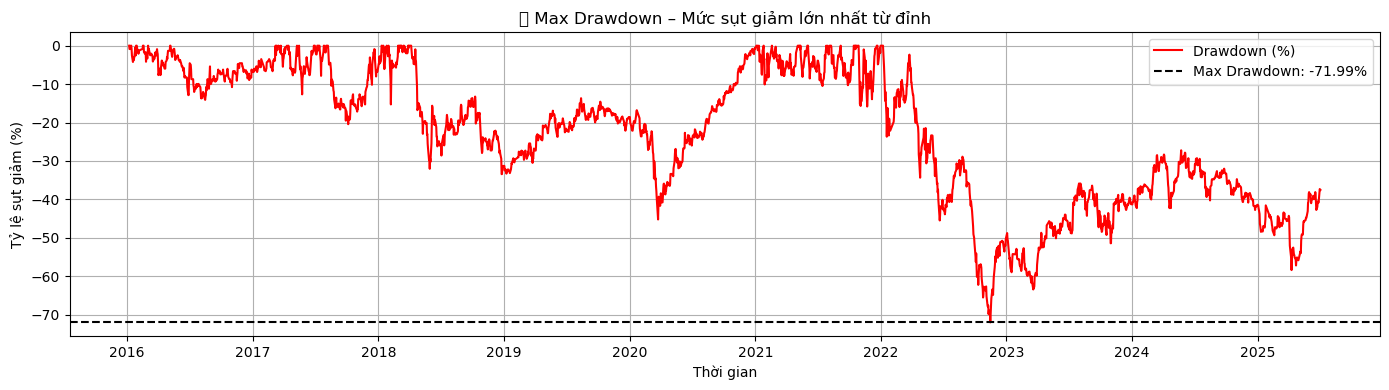

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Đọc dữ liệu đã làm sạch
df = pd.read_csv("NLG_cleaned.csv")
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# ==========================
# 1. Daily Return (% thay đổi ngày)
# ==========================
df['daily_return'] = df['close_price_adjusted'].pct_change() * 100

plt.figure(figsize=(14, 4))
plt.plot(df['daily_return'], color='purple', label='Daily Return (%)')
plt.axhline(0, linestyle='--', color='gray', alpha=0.5)
plt.title("📈 Daily Return – Tỷ lệ thay đổi giá hằng ngày")
plt.xlabel("Thời gian")
plt.ylabel("Tỷ lệ (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==========================
# 2. Volatility – rolling std trong 20 ngày (%)
# ==========================
df['volatility_20d'] = df['daily_return'].rolling(window=20).std()

plt.figure(figsize=(14, 4))
plt.plot(df['volatility_20d'], color='orange', label='Volatility 20 ngày')
plt.title("⚡ Volatility – Độ biến động 20 ngày")
plt.xlabel("Thời gian")
plt.ylabel("Biến động (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==========================
# 3. Max Drawdown (MDD)
# ==========================
df['cummax'] = df['close_price_adjusted'].cummax()
df['drawdown'] = (df['close_price_adjusted'] - df['cummax']) / df['cummax'] * 100

max_dd = df['drawdown'].min()

plt.figure(figsize=(14, 4))
plt.plot(df['drawdown'], label='Drawdown (%)', color='red')
plt.axhline(max_dd, linestyle='--', color='black', label=f'Max Drawdown: {max_dd:.2f}%')
plt.title("📉 Max Drawdown – Mức sụt giảm lớn nhất từ đỉnh")
plt.xlabel("Thời gian")
plt.ylabel("Tỷ lệ sụt giảm (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# BƯỚC 4 – PHASE 1: Phát hiện tín hiệu kỹ thuật đơn giản:

✅ MA Crossover: khi MA10 cắt lên MA20 (Golden Cross) và ngược lại (Death Cross)

🔻 RSI < 30: vùng quá bán → tín hiệu đảo chiều tăng tiềm năng

🔺 RSI > 70: vùng quá mua → tín hiệu điều chỉnh giảm

C:\Users\Welcome\AppData\Local\Temp\ipykernel_26012\1872205615.py:58: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Welcome\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


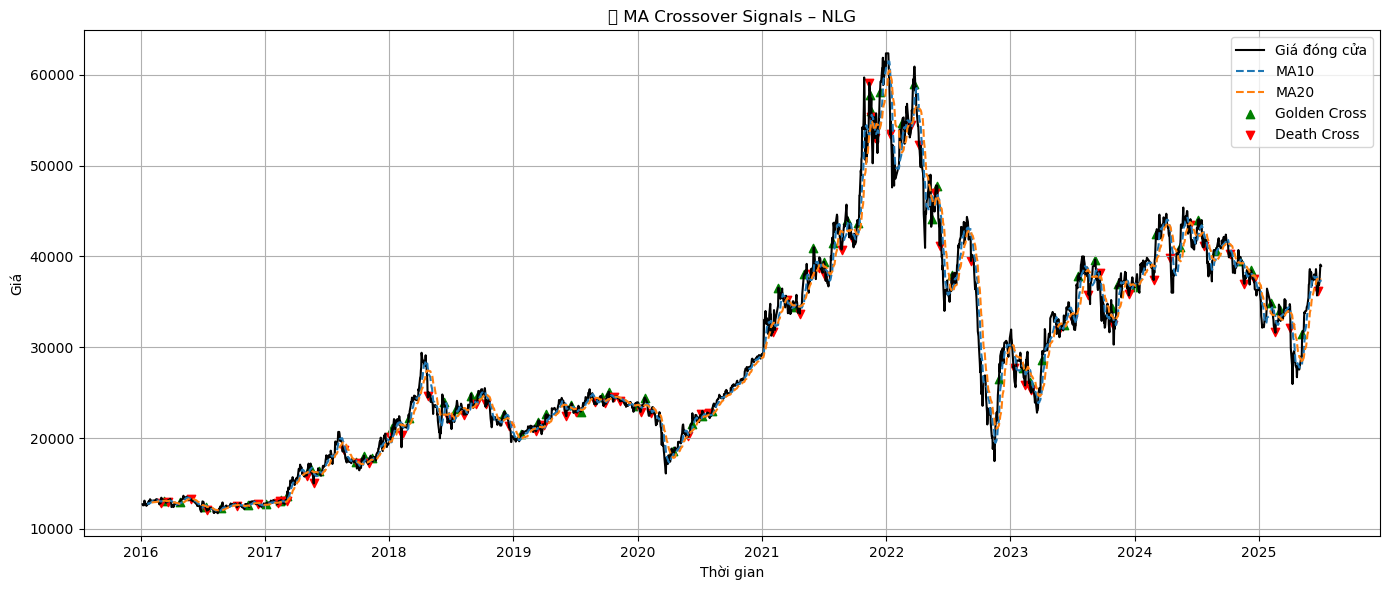

C:\Users\Welcome\AppData\Local\Temp\ipykernel_26012\1872205615.py:80: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


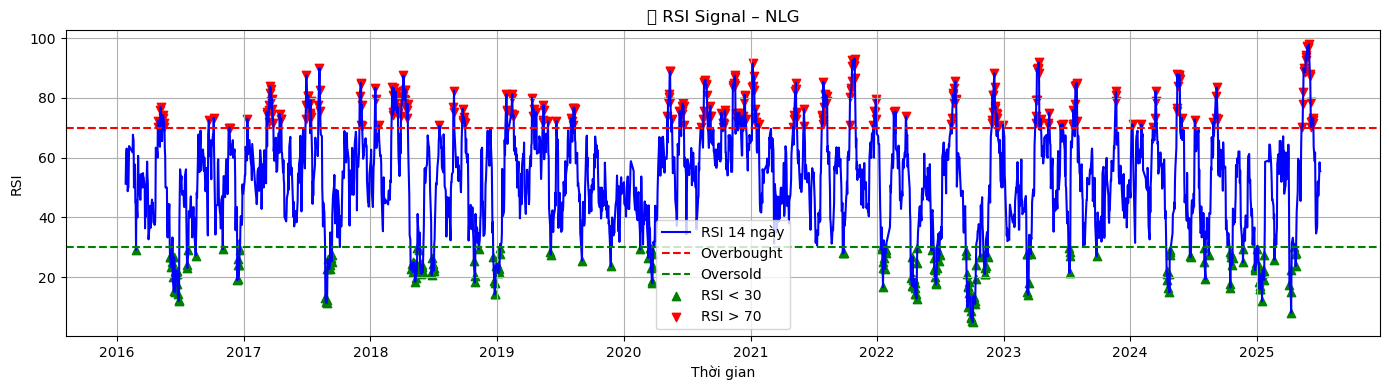

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Đọc dữ liệu đã làm sạch
df = pd.read_csv("NLG_cleaned.csv")
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# TÍNH MA10, MA20 nếu chưa có
df['MA10'] = df['close_price_adjusted'].rolling(window=10).mean()
df['MA20'] = df['close_price_adjusted'].rolling(window=20).mean()

# TÍNH RSI nếu chưa có
delta = df['close_price_adjusted'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# =====================================
# 1️⃣ Tín hiệu MA Crossover
# =====================================
df['signal_ma'] = 0
df.loc[(df['MA10'] > df['MA20']) & (df['MA10'].shift(1) <= df['MA20'].shift(1)), 'signal_ma'] = 1  # Golden Cross
df.loc[(df['MA10'] < df['MA20']) & (df['MA10'].shift(1) >= df['MA20'].shift(1)), 'signal_ma'] = -1  # Death Cross

# =====================================
# 2️⃣ Tín hiệu RSI
# =====================================
df['signal_rsi'] = 0
df.loc[df['RSI'] < 30, 'signal_rsi'] = 1   # Mua vào (quá bán)
df.loc[df['RSI'] > 70, 'signal_rsi'] = -1  # Bán ra (quá mua)

# =====================================
# VẼ TÍN HIỆU MA Crossover trên giá
# =====================================
plt.figure(figsize=(14, 6))
plt.plot(df['close_price_adjusted'], label='Giá đóng cửa', color='black')
plt.plot(df['MA10'], label='MA10', linestyle='--')
plt.plot(df['MA20'], label='MA20', linestyle='--')

# Vẽ điểm Golden Cross
golden = df[df['signal_ma'] == 1]
plt.scatter(golden.index, golden['close_price_adjusted'], marker='^', color='green', label='Golden Cross')

# Vẽ điểm Death Cross
death = df[df['signal_ma'] == -1]
plt.scatter(death.index, death['close_price_adjusted'], marker='v', color='red', label='Death Cross')

plt.title("📌 MA Crossover Signals – NLG")
plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================
# VẼ TÍN HIỆU RSI
# =====================================
plt.figure(figsize=(14, 4))
plt.plot(df['RSI'], label='RSI 14 ngày', color='blue')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')

# Đánh dấu điểm tín hiệu RSI
plt.scatter(df[df['signal_rsi'] == 1].index, df[df['signal_rsi'] == 1]['RSI'],
            color='green', marker='^', label='RSI < 30')
plt.scatter(df[df['signal_rsi'] == -1].index, df[df['signal_rsi'] == -1]['RSI'],
            color='red', marker='v', label='RSI > 70')

plt.title("📌 RSI Signal – NLG")
plt.xlabel("Thời gian")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# BƯỚC 5 – PHASE 1: Tổng hợp các tín hiệu kỹ thuật vào DataFrame và lưu thành file .csv để dùng cho phân tích chiến lược, dashboard hoặc mô hình AI.

In [11]:
import pandas as pd

# Đọc dữ liệu đã làm sạch
df = pd.read_csv("NLG_cleaned.csv")
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# TÍNH MA10, MA20
df['MA10'] = df['close_price_adjusted'].rolling(window=10).mean()
df['MA20'] = df['close_price_adjusted'].rolling(window=20).mean()

# TÍNH RSI
delta = df['close_price_adjusted'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# DAILY RETURN
df['daily_return'] = df['close_price_adjusted'].pct_change() * 100

# MAX DRAWDOWN
df['cummax'] = df['close_price_adjusted'].cummax()
df['drawdown'] = (df['close_price_adjusted'] - df['cummax']) / df['cummax'] * 100

# ========== TÍN HIỆU MA CROSS ==========
df['signal_ma'] = 0
df.loc[(df['MA10'] > df['MA20']) & (df['MA10'].shift(1) <= df['MA20'].shift(1)), 'signal_ma'] = 1
df.loc[(df['MA10'] < df['MA20']) & (df['MA10'].shift(1) >= df['MA20'].shift(1)), 'signal_ma'] = -1

# ========== TÍN HIỆU RSI ==========
df['signal_rsi'] = 0
df.loc[df['RSI'] < 30, 'signal_rsi'] = 1
df.loc[df['RSI'] > 70, 'signal_rsi'] = -1

# ========== TỔNG HỢP TÍN HIỆU ==========
df['signal_combined'] = df['signal_ma'] + df['signal_rsi']

# LỌC CÁC CỘT QUAN TRỌNG
df_signals = df[[
    'close_price_adjusted', 'MA10', 'MA20', 'RSI', 'daily_return',
    'drawdown', 'signal_ma', 'signal_rsi', 'signal_combined'
]].dropna()

# LƯU FILE
df_signals.to_csv("NLG_signals.csv")
print("✅ Đã lưu tín hiệu kỹ thuật vào file NLG_signals.csv")


✅ Đã lưu tín hiệu kỹ thuật vào file NLG_signals.csv


In [12]:
# view_signals.py

import pandas as pd

# Đọc dữ liệu từ file CSV
df = pd.read_csv("NLG_signals.csv")

# Hiển thị 10 dòng đầu tiên
print("📊 XEM TRƯỚC 10 DÒNG TÍN HIỆU:")
print(df.head(10))

# Hiển thị thông tin tổng quan
print("\n📌 THÔNG TIN CHUNG:")
print(df.info())

# Hiển thị thống kê mô tả
print("\n📈 THỐNG KÊ MÔ TẢ:")
print(df.describe())


📊 XEM TRƯỚC 10 DÒNG TÍN HIỆU:
         time  close_price_adjusted          MA10          MA20        RSI  \
0  2016-02-03          12992.482085  12986.929742  12881.435229  50.000000   
1  2016-02-04          13048.005512  13025.796141  12898.092258  56.410256   
2  2016-02-05          13103.528940  13064.662541  12923.077800  63.888889   
3  2016-02-15          13159.052368  13075.767226  12950.839514  61.764706   
4  2016-02-16          13270.099223  13125.738311  12959.168028  67.647059   
5  2016-02-17          13270.099223  13142.395340  12967.496542  66.666667   
6  2016-02-18          13270.099223  13153.500025  12981.377399  65.625000   
7  2016-02-19          13048.005512  13131.290654  12995.258256  50.000000   
8  2016-02-22          12992.482085  13125.738311  13017.467627  57.692308   
9  2016-02-23          12992.482085  13114.633626  13031.348484  45.000000   

   daily_return  drawdown  signal_ma  signal_rsi  signal_combined  
0     -0.847458  -2.09205          0       